In [27]:
# Installation des bibliothèques nécessaires
!pip install lightgbm xgboost catboost --quiet

  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:000:00:0100:01


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# style
plt.style.use('ggplot')

import seaborn as sns
import re

In [2]:
# 📂 Chargement des données
base_path = "https://raw.githubusercontent.com/Jude200/Hello-Word/refs/heads/master/folder_1/"

train_df = pd.read_csv(base_path + "Train.csv")
test_df = pd.read_csv(base_path + "Test.csv")
description_df = pd.read_csv(base_path + "VariableDefinitions.csv")

print(f"📊 Train shape: {train_df.shape}")
print(f"📊 Test shape: {test_df.shape}")


📊 Train shape: (9618, 39)
📊 Test shape: (2405, 38)


Text(0.5, 1.0, 'Distribution of Target Variable')

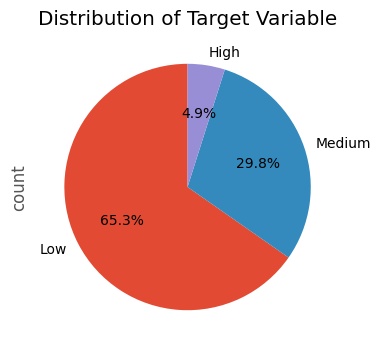

In [3]:
# Pie
plt.figure(figsize=(4, 4))
train_df['Target'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')

## Analyse des valeurs manquantes

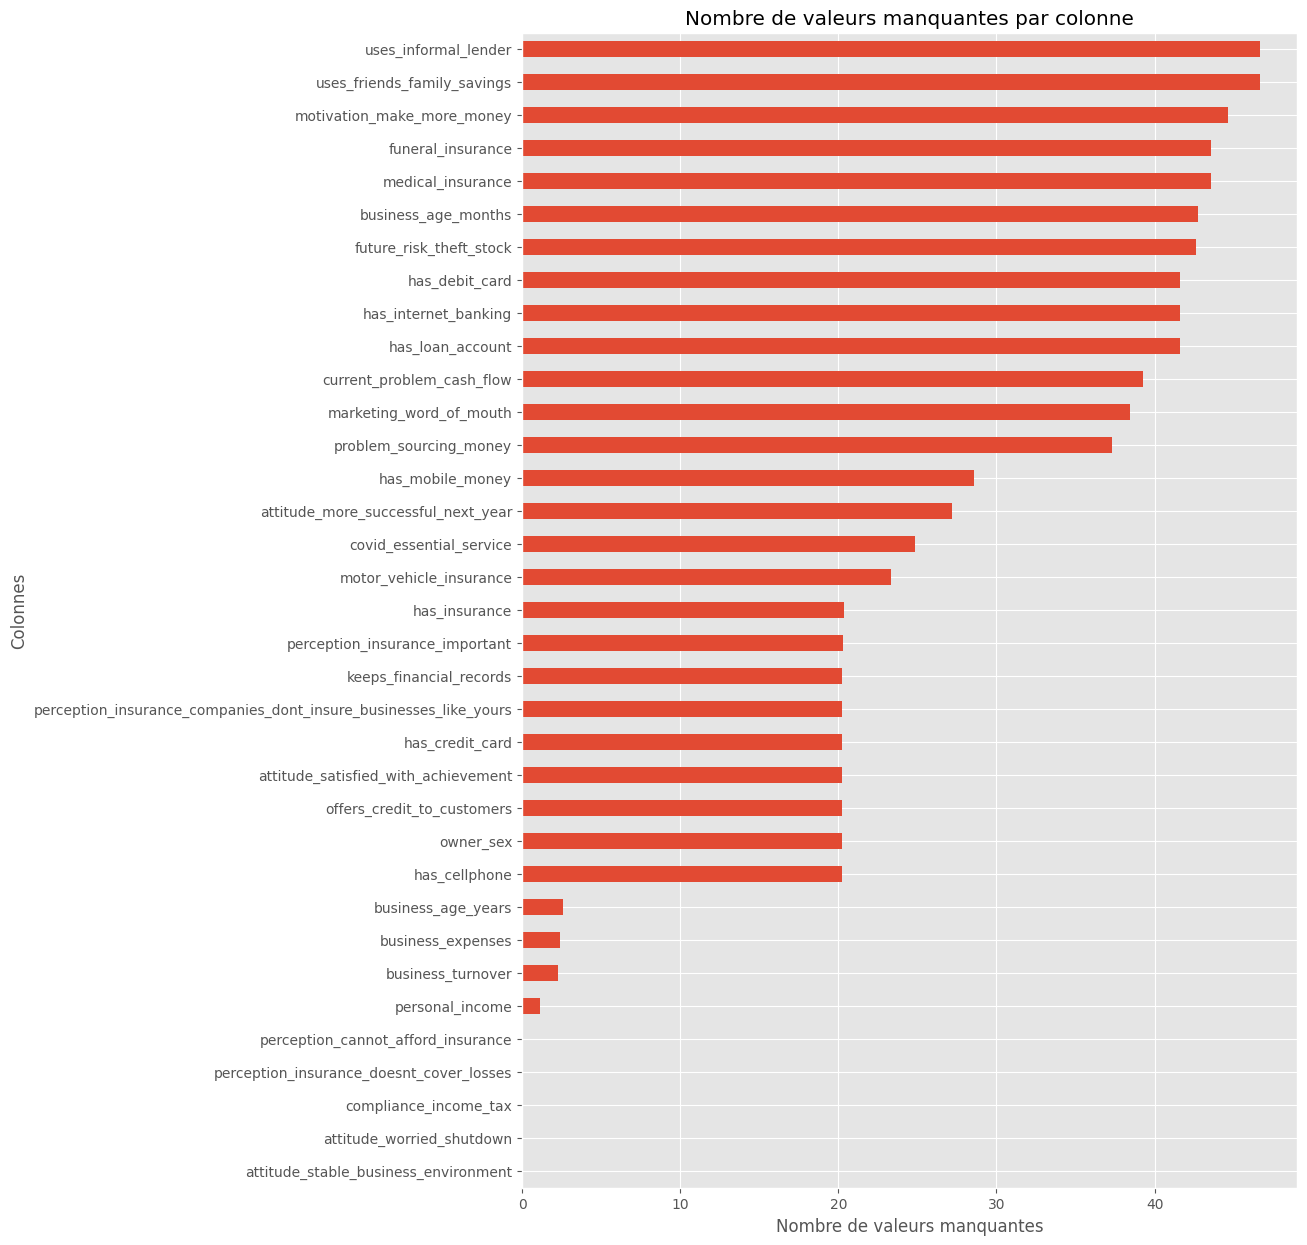

In [4]:
# Analyse des valeurs manquantes
def plot_missing_data(df):
    missing_data = df.isnull().sum() / len(df) * 100
    missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
    
    if missing_data.empty:
        print("Aucune valeur manquante dans le DataFrame.")
        return
    
    plt.figure(figsize=(10, 15))
    missing_data.plot.barh()
    plt.title("Nombre de valeurs manquantes par colonne")
    plt.xlabel("Nombre de valeurs manquantes")
    plt.ylabel("Colonnes")
    plt.show()
    
plot_missing_data(train_df)

In [5]:
# Exclude ID and country columns
exclude_cols = ['ID', 'country']
# Numerical features
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Categorical features
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns {len(numerical_cols)} : {numerical_cols}")
print(f"Categorical columns {len(categorical_cols)} : {categorical_cols}")

print("\nPourcentage de valeurs manquantes dans les colonnes numériques :")
print(train_df[numerical_cols].isnull().sum() * 100 / len(train_df[numerical_cols]))


Numerical columns 6 : ['owner_age', 'personal_income', 'business_expenses', 'business_turnover', 'business_age_years', 'business_age_months']
Categorical columns 33 : ['ID', 'country', 'attitude_stable_business_environment', 'attitude_worried_shutdown', 'compliance_income_tax', 'perception_insurance_doesnt_cover_losses', 'perception_cannot_afford_insurance', 'motor_vehicle_insurance', 'has_mobile_money', 'current_problem_cash_flow', 'has_cellphone', 'owner_sex', 'offers_credit_to_customers', 'attitude_satisfied_with_achievement', 'has_credit_card', 'keeps_financial_records', 'perception_insurance_companies_dont_insure_businesses_like_yours', 'perception_insurance_important', 'has_insurance', 'covid_essential_service', 'attitude_more_successful_next_year', 'problem_sourcing_money', 'marketing_word_of_mouth', 'has_loan_account', 'has_internet_banking', 'has_debit_card', 'future_risk_theft_stock', 'medical_insurance', 'funeral_insurance', 'motivation_make_more_money', 'uses_friends_family

In [6]:
train_df[numerical_cols].describe()

,owner_age,personal_income,business_expenses,business_turnover,business_age_years,business_age_months
count,9618.000000,9.509000e+03,9.389000e+03,9.402000e+03,9366.000000,5507.000000
mean,41.705344,2.627345e+05,4.583838e+05,1.348210e+06,7.030536,3.636281
std,13.314010,2.566268e+06,6.184746e+06,8.804741e+06,7.650349,3.386488
min,18.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,32.000000,3.000000e+02,7.000000e+02,1.500000e+03,2.000000,0.000000
50%,40.000000,2.000000e+03,3.000000e+03,6.000000e+03,4.000000,3.000000
75%,50.000000,2.500000e+04,2.500000e+04,5.000000e+04,10.000000,6.000000
max,103.000000,1.500000e+08,5.000000e+08,4.200000e+08,60.000000,11.000000


In [7]:
binary_cols = [col for col in categorical_cols if train_df[col].nunique() == 2]
print(f"\nColonnes binaires ({len(binary_cols)}): {binary_cols}")

# Description des variables binaires
print("\nDescription des variables binaires :")
for col in binary_cols:
    description = description_df[description_df['VARIABLE_NAME'] == col]['VARIABLE_DESCRIPTION'].dropna().values
    if len(description) > 0:
        print(f"\t- {col}: {description[0]}")
    else:
        print(f"\t- {col}: Description non trouvée.")


Colonnes binaires (7): ['has_cellphone', 'owner_sex', 'has_insurance', 'problem_sourcing_money', 'marketing_word_of_mouth', 'future_risk_theft_stock', 'motivation_make_more_money']

Description des variables binaires :
	- has_cellphone: Business has access to or uses a cell phone
	- owner_sex: Gender/sex of the business owner
	- has_insurance: Whether the business has any kind of insurance
	- problem_sourcing_money: Faced problem with sourcing money when starting or taking over the business
	- marketing_word_of_mouth: Business uses word of mouth as a method of marketing or advertising
	- future_risk_theft_stock: Business is likely to face risk of theft of business stock in the future
	- motivation_make_more_money: Motivation to start the business: To make more money or provide for family


In [8]:
# Select variables starting with 'has_'
has_cols = [col for col in train_df.columns if re.match(r'^has_', col)]
print(f"\nColonnes commençant par 'has_' ({len(has_cols)}): {has_cols}")

train_df["has_mobile_money"].unique()


Colonnes commençant par 'has_' (7): ['has_mobile_money', 'has_cellphone', 'has_credit_card', 'has_insurance', 'has_loan_account', 'has_internet_banking', 'has_debit_card']


array(['Have now', 'Never had', nan, "Used to have but don't have now",
       'Used to have but don’t have now', "Don't know"], dtype=object)

🟢 *Certaines variables catégorielles sont sensibles au apostrophes*

In [9]:
# Categorical features with 5 unique values
five_unique_cols = [col for col in categorical_cols if train_df[col].nunique() == 5]
print(f"\nColonnes catégorielles avec 5 valeurs uniques ({len(five_unique_cols)}): {five_unique_cols}")


Colonnes catégorielles avec 5 valeurs uniques (6): ['has_mobile_money', 'has_credit_card', 'perception_insurance_companies_dont_insure_businesses_like_yours', 'perception_insurance_important', 'has_debit_card', 'funeral_insurance']


In [10]:
train_df["perception_insurance_companies_dont_insure_businesses_like_yours"].unique()

array(['Yes', 'No', 'Don?t know / doesn?t apply', nan, "Don't know",
       "Don't Know"], dtype=object)

In [11]:
train_df["uses_friends_family_savings"].unique()

array(['Never had', nan, "Used to have but don't have now", 'Have now',
       'Used to have but don’t have now', "Don't know",
       'Don’t know (Do not show)'], dtype=object)

🟢 *Certaines variables catégorielles sont sensibles à la casse*

In [12]:
# Variables with more unique values
train_df[categorical_cols].apply(lambda x: x.unique())

,0
ID,"[ID_3CFL0U, ID_XWI7G3, ID_TY93LV, ID_9OP2C8, I..."
country,"[eswatini, zimbabwe, malawi, lesotho]"
attitude_stable_business_environment,"[Yes, No, Don’t know or N/A, nan]"
attitude_worried_shutdown,"[No, Yes, Don’t know or N/A, nan]"
compliance_income_tax,"[No, Yes, Don’t know, Refused, nan]"
perception_insurance_doesnt_cover_losses,"[No, Don't know, Yes, nan]"
perception_cannot_afford_insurance,"[Yes, No, Don't know, nan]"
motor_vehicle_insurance,"[Never had, Have now, nan, Used to have but do..."
has_mobile_money,"[Have now, Never had, nan, Used to have but do..."
current_problem_cash_flow,"[Yes, nan, No, 0]"


In [13]:
print(description_df[description_df['VARIABLE_NAME'] == 'keeps_financial_records']['VARIABLE_DESCRIPTION'].values)
train_df["keeps_financial_records"].unique()

['Whether the business keeps financial records']


array(['Yes, always', 'No', nan, 'Yes, sometimes', 'Yes'], dtype=object)

In [14]:
train_df["compliance_income_tax"].unique()

array(['No', 'Yes', 'Don’t know', 'Refused', nan], dtype=object)

In [15]:
# Categorical features with 6 unique values
five_unique_cols = [col for col in categorical_cols if train_df[col].nunique() == 6]
print(f"\nColonnes catégorielles avec 6 valeurs uniques ({len(five_unique_cols)}): {five_unique_cols}")


Colonnes catégorielles avec 6 valeurs uniques (5): ['has_loan_account', 'has_internet_banking', 'medical_insurance', 'uses_friends_family_savings', 'uses_informal_lender']


In [ ]:
train_df["has_loan_account"].unique() 

array(['Never had', nan, "Used to have but don't have now",
       'Used to have but don’t have now', 'Have now',
       'Don’t know (Do not show)', "Don't know"], dtype=object)

In [17]:
def structured_data(train_df, test_df=None):
    """
    Nettoie et standardise les données avant le prétraitement.
    - Normalise les apostrophes (curly -> straight)
    - Normalise la casse (uniformisation des valeurs catégorielles)
    - Corrige les incohérences dans les valeurs textuelles
    """
    # Combiner train et test pour un traitement cohérent (si test_df est fourni)
    if test_df is not None:
        test_df['Target'] = np.nan  # Placeholder
        all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    else:
        all_data = train_df.copy()

    print(f"Taille initiale: {all_data.shape}")
    
    # Définir les colonnes à exclure et à traiter DANS la fonction 
    _exclude_cols = ['ID', 'Target', 'country']
    _categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()
    cols_to_process = [col for col in _categorical_cols if col not in _exclude_cols]
    
    print(f"Colonnes catégorielles à traiter: {len(cols_to_process)}")
    
    # ==============================================================================
    # 1. NORMALISATION DES APOSTROPHES
    # ==============================================================================
    curly_apostrophes = ["\u2019", "\u2018", "\u201B", "?"]  # ', ', ‛, ?
    
    for col in cols_to_process:
        for apos in curly_apostrophes:
            all_data[col] = all_data[col].apply(
                lambda x: x.replace(apos, "'") if isinstance(x, str) else x
            )
    print("✅ Apostrophes normalisées")
    
    # ==============================================================================
    # 2. NORMALISATION DE LA CASSE + ESPACES
    # ==============================================================================
    for col in cols_to_process:
        all_data[col] = all_data[col].apply(
            lambda x: ' '.join(x.strip().split()).capitalize() if isinstance(x, str) else x
        )
    print("✅ Casse normalisée (capitalize) + espaces nettoyés")
    
    # ==============================================================================
    # 3. CORRECTION DES VALEURS SPÉCIFIQUES
    # ==============================================================================
    def assign_value_correction(s):
        if not isinstance(s, str):
            return s
        
        # Valeurs positives -> "Yes"
        if s in ["Yes", "Have now", "Yes, sometimes", "1"]:
            return "Yes"
        
        # Valeurs négatives -> "No"  
        if s in ["No", "Never had", "0"]:
            return "No"
        
        # Valeur "ex-utilisateur" -> garder comme catégorie distincte
        if s == "Used to have but don't have now":
            return "Used to have"
        
        # Valeurs inconnues -> NaN
        unknown_values = ["Don't know", "Not known", "Do not know", "Unknown", "N/a", "Refused"]
        if s in unknown_values or "don't know" in s.lower() or "do not know" in s.lower():
            return np.nan
        
        # Retourner la valeur originale
        return s
    
    # Appliquer les corrections
    for col in cols_to_process:
        all_data[col] = all_data[col].apply(assign_value_correction)
    print("✅ Valeurs spécifiques corrigées")
    
    
    # Séparer à nouveau Train et Test
    if test_df is not None:
        train_structured = all_data[~all_data['Target'].isnull()].copy()
        test_structured = all_data[all_data['Target'].isnull()].drop(columns=['Target']).copy()
        print(f"\n✅ Données structurées - Train: {train_structured.shape}, Test: {test_structured.shape}")
        return train_structured, test_structured
    else:
        return all_data

# Appliquer le nettoyage structurel
train_df_structured, test_df_structured = structured_data(train_df, test_df)

Taille initiale: (12023, 39)
Colonnes catégorielles à traiter: 30
✅ Apostrophes normalisées
✅ Casse normalisée (capitalize) + espaces nettoyés
✅ Valeurs spécifiques corrigées

✅ Données structurées - Train: (9618, 39), Test: (2405, 38)


In [18]:
# Variables with more unique values
train_df_structured[categorical_cols].apply(lambda x: x.unique())

,0
ID,"[ID_3CFL0U, ID_XWI7G3, ID_TY93LV, ID_9OP2C8, I..."
country,"[eswatini, zimbabwe, malawi, lesotho]"
attitude_stable_business_environment,"[Yes, No, nan]"
attitude_worried_shutdown,"[No, Yes, nan]"
compliance_income_tax,"[No, Yes, nan]"
perception_insurance_doesnt_cover_losses,"[No, nan, Yes]"
perception_cannot_afford_insurance,"[Yes, No, nan]"
motor_vehicle_insurance,"[No, Yes, nan, Used to have]"
has_mobile_money,"[Yes, No, nan, Used to have]"
current_problem_cash_flow,"[Yes, nan, No]"


In [19]:
def preprocess_data(train_df, test_df=None):
    # Combiner train et test pour un traitement cohérent (si test_df est fourni)
    if test_df is not None:
        test_df['Target'] = np.nan # Placeholder
        all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    else:
        all_data = train_df.copy()

    print(f"Taille initiale: {all_data.shape}")

    # ==============================================================================
    # 1. GESTION DES VALEURS MANQUANTES (MISSING VALUES)
    # ==============================================================================
    
    # --- A. Variables Numériques Financières (Faible taux de manquants) ---
    # Stratégie : Médiane (car les revenus sont souvent biaisés vers la droite)
    fin_cols = ['personal_income', 'business_expenses', 'business_turnover']
    for col in fin_cols:
        # On remplit par la médiane groupée par Pays (le coût de la vie dépend du pays)
        all_data[col] = all_data.groupby('country')[col].transform(lambda x: x.fillna(x.median()))

    # --- B. Variables Temporelles (Business Age) ---
    # Stratégie : Si 'months' est manquant, on suppose 0. Si 'years' est manquant, médiane.
    all_data['business_age_months'] = all_data['business_age_months'].fillna(0)
    all_data['business_age_years'] = all_data['business_age_years'].fillna(all_data['business_age_years'].median())
    
    # Création d'une variable unifiée précise
    all_data['total_business_age_months'] = (all_data['business_age_years'] * 12) + all_data['business_age_months']

    # On peut supprimer les anciennes colonnes si besoin
    all_data = all_data.drop(columns=['business_age_years', 'business_age_months'])
    
    # --- C. Variables Catégorielles/Binaires à fort taux de manquants (>20%) ---
    # Stratégie : Créer une classe "Missing" ou -1. L'absence d'info EST une info.
    # Liste basée sur ton fichier CSV
    
    high_missing_cols = all_data.columns[all_data.isnull().mean() > 0.2].tolist()
    high_missing_cols.remove("Target")
    
    # Pour les variables catégorielles non binaire
    print(f"Colonnes avec fort taux de manquants (>20%) : {len(high_missing_cols)}")
    
    # On identifie les colonnes objets et numériques dans cette liste
    for col in high_missing_cols:
        if col in all_data.columns:
            if all_data[col].dtype == 'object':
                all_data[col] = all_data[col].fillna('Unknown')
            else:
                # Pour les variables binaires numériques (0/1), on met -1 pour "Manquant"
                all_data[col] = all_data[col].fillna(-1)

    # --- D. Le reste des variables (Faible taux de manquants) ---
    # Stratégie : Mode (Valeur la plus fréquente)
    remaining_cols = all_data.columns[all_data.isnull().any()].tolist()
    # On exclut la Target si elle est NaN (cas du test set)
    remaining_cols = [c for c in remaining_cols if c != 'Target']
    
    for col in remaining_cols:
        if all_data[col].dtype == 'object':
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
        else:
            all_data[col] = all_data[col].fillna(all_data[col].median())

    print("✅ Gestion des valeurs manquantes terminée.")

    # ==============================================================================
    # 2. FEATURES ENGINEERING (CRÉATION DE VARIABLES)
    # ==============================================================================
    
    # --- A. Ratios Financiers (Crucial pour la santé financière) ---
    # Profit approximatif
    all_data['approx_profit'] = all_data['business_turnover'] - all_data['business_expenses']
    
    # Marge bénéficiaire (Attention division par zéro)
    all_data['profit_margin'] = all_data['approx_profit'] / (all_data['business_turnover'] + 1)
    
    # Ratio Dépenses / Revenu
    all_data['expense_ratio'] = all_data['business_expenses'] / (all_data['business_turnover'] + 1)
    
    # Capacité personnelle vs Business (Support du propriétaire)
    all_data['personal_vs_business_income'] = all_data['personal_income'] / (all_data['business_turnover'] + 1)

    # --- B. Score d'Inclusion Financière ---
    # On compte combien d'outils financiers modernes l'entreprise utilise
    # (On suppose que 'Yes' ou 1 indique la présence. On doit vérifier l'encodage plus tard)
    # Ici on fait une somme simple des indicateurs positifs
    
    financial_tools = ['has_mobile_money', 'has_internet_banking', 'has_debit_card', 
                       'has_credit_card', 'has_loan_account']
    
    # Fonction pour convertir en 1 si positif, 0 sinon (en gérant les -1 ou 'Unknown')
    def check_positive(x):
        return 1 if x in [1, 'Yes', 'True', '1', 'Have now'] else 0

    all_data['financial_access_score'] = 0
    for col in financial_tools:
        if col in all_data.columns:
            all_data['financial_access_score'] += all_data[col].apply(check_positive)

    # --- C. Score de Protection (Assurances) ---
    insurance_cols = ['motor_vehicle_insurance', 'medical_insurance', 'funeral_insurance', 'has_insurance']
    all_data['insurance_score'] = 0
    for col in insurance_cols:
        if col in all_data.columns:
            all_data['insurance_score'] += all_data[col].apply(check_positive)

    # --- D. Transformation Logarithmique (Log Transform) ---
    # Les données financières sont très étalées (Skewed). Le Log aide les modèles.
    for col in ['personal_income', 'business_expenses', 'business_turnover', 'approx_profit']:
        # On utilise log1p pour gérer les zéros et on prend la valeur absolue pour les profits négatifs
        all_data[f'log_{col}'] = np.log1p(np.abs(all_data[col]))

    print("✅ Feature Engineering terminé.")
    
    # Séparer à nouveau Train et Test
    if test_df is not None:
        train_processed = all_data[~all_data['Target'].isnull()].copy()
        test_processed = all_data[all_data['Target'].isnull()].drop(columns=['Target']).copy()
        print(f"Taille train après prétraitement: {train_processed.shape}")
        print(f"Taille test après prétraitement: {test_processed.shape}")
        return train_processed, test_processed
    else:
        return all_data

train_clean, test_clean = preprocess_data(train_df_structured, test_df_structured)

Taille initiale: (12023, 39)
Colonnes avec fort taux de manquants (>20%) : 26
✅ Gestion des valeurs manquantes terminée.
✅ Feature Engineering terminé.
Taille train après prétraitement: (9618, 48)
Taille test après prétraitement: (2405, 47)


In [ ]:
train_clean[categorical_cols].apply(lambda x: x.unique())

,0
ID,"[ID_3CFL0U, ID_XWI7G3, ID_TY93LV, ID_9OP2C8, I..."
country,"[eswatini, zimbabwe, malawi, lesotho]"
attitude_stable_business_environment,"[Yes, No]"
attitude_worried_shutdown,"[No, Yes]"
compliance_income_tax,"[No, Yes]"
perception_insurance_doesnt_cover_losses,"[No, Unknown, Yes]"
perception_cannot_afford_insurance,"[Yes, No]"
motor_vehicle_insurance,"[No, Yes, Unknown, Used to have]"
has_mobile_money,"[Yes, No, Unknown, Used to have]"
current_problem_cash_flow,"[Yes, Unknown, No]"


In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [22]:
def encode_and_scale(train_df, test_df):
    """
    Encode les variables catégorielles et normalise les features.
    Version robuste sans data leakage.
    
    Returns:
        X_train, y_train, X_test, le_target, scaler (pour réutilisation)
    """
    # ⚠️ Copie pour éviter de modifier les DataFrames originaux
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # 1. Marquage et séparation de la Target
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    
    target = train_df['Target'].copy()
    train_df = train_df.drop(columns=['Target'])
    
    # Concaténation pour encodage cohérent
    all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    
    print("=" * 50)
    print("ETAPE 2 : ENCODAGE & NORMALISATION")
    print("=" * 50)

    # ---------------------------------------------------------
    # A. Mapping Manuel des variables Binaires (Yes/No -> 1/0)
    # ---------------------------------------------------------
    binary_map = {'Yes': 1, 'No': 0, 'True': 1, 'False': 0, 'Unknown': -1, 'Used to have': 0.5}
    
    binary_encoded_cols = []
    for col in all_data.select_dtypes(include=['object']).columns:
        unique_vals = set(all_data[col].dropna().unique())
        # Si la colonne ne contient que des valeurs binaires connues
        if unique_vals.issubset({'Yes', 'No', 'Unknown', 'Used to have'}):
            print(f"   Mapping binaire: {col}")
            all_data[col] = all_data[col].map(binary_map)
            all_data[col] = all_data[col].fillna(-1)  # NaN restants -> -1
            binary_encoded_cols.append(col)

    # ---------------------------------------------------------
    # B. One-Hot Encoding pour les variables catégorielles restantes
    # ---------------------------------------------------------
    cat_cols = all_data.select_dtypes(include=['object']).columns.tolist()
    cols_to_exclude = ['ID']
    cat_cols = [c for c in cat_cols if c not in cols_to_exclude]
    
    print(f"\nVariables catégorielles à encoder (One-Hot): {cat_cols}")
    
    all_data = pd.get_dummies(all_data, columns=cat_cols, dummy_na=False)
    
    print(f"Nouvelle taille après encodage: {all_data.shape}")

    # ---------------------------------------------------------
    # C. Identification des colonnes à normaliser
    # ---------------------------------------------------------
    exclude_from_scaling = ['ID', 'is_train']
    
    # On normalise les colonnes numériques continues (pas les binaires 0/1 ou -1/0/1)
    num_cols = []
    for col in all_data.columns:
        if col in exclude_from_scaling:
            continue
        # Exclure les colonnes binaires (issues du OHE ou du mapping)
        unique_count = all_data[col].nunique()
        if unique_count > 3:  # Plus de 3 valeurs uniques = probablement continue
            num_cols.append(col)
        elif col in binary_encoded_cols and all_data[col].min() < 0:
            # Colonnes avec -1, 0, 1 (binaires avec Unknown)
            continue
    
    print(f"\nNormalisation de {len(num_cols)} variables numériques continues...")

    # ---------------------------------------------------------
    # D. Normalisation SANS DATA LEAKAGE ✅
    # ---------------------------------------------------------
    # Séparer AVANT de fit le scaler
    train_mask = all_data['is_train'] == 1
    
    scaler = StandardScaler()
    
    # Fit UNIQUEMENT sur le train
    scaler.fit(all_data.loc[train_mask, num_cols])
    
    # Transform sur train ET test
    all_data[num_cols] = scaler.transform(all_data[num_cols])

    # ---------------------------------------------------------
    # E. Séparation et Préparation Finale
    # ---------------------------------------------------------
    X_train = all_data[all_data['is_train'] == 1].drop(columns=['ID', 'is_train'])
    X_test = all_data[all_data['is_train'] == 0].drop(columns=['ID', 'is_train'])
    
    # Encodage de la Target
    le_target = LabelEncoder()
    y_train = le_target.fit_transform(target)
    
    print("\n✅ Prétraitement terminé !")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Classes Target: {le_target.classes_}")

    # Retourner aussi le scaler pour pouvoir l'utiliser sur de nouvelles données
    return X_train, y_train, X_test, le_target, scaler

# --- UTILISATION ---
X_train, y_train, X_test, le_target, scaler = encode_and_scale(train_clean, test_clean)

ETAPE 2 : ENCODAGE & NORMALISATION
   Mapping binaire: attitude_stable_business_environment
   Mapping binaire: attitude_worried_shutdown
   Mapping binaire: compliance_income_tax
   Mapping binaire: perception_insurance_doesnt_cover_losses
   Mapping binaire: perception_cannot_afford_insurance
   Mapping binaire: motor_vehicle_insurance
   Mapping binaire: has_mobile_money
   Mapping binaire: current_problem_cash_flow
   Mapping binaire: has_cellphone
   Mapping binaire: attitude_satisfied_with_achievement
   Mapping binaire: has_credit_card
   Mapping binaire: perception_insurance_companies_dont_insure_businesses_like_yours
   Mapping binaire: perception_insurance_important
   Mapping binaire: has_insurance
   Mapping binaire: covid_essential_service
   Mapping binaire: attitude_more_successful_next_year
   Mapping binaire: problem_sourcing_money
   Mapping binaire: marketing_word_of_mouth
   Mapping binaire: has_loan_account
   Mapping binaire: has_internet_banking
   Mapping binair

In [33]:
import re

from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold

In [42]:
def create_submission_file(predictions, file_name="submission.csv"):
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'Target': predictions
    })
    submission_df.to_csv(file_name, index=False)
    print(f"Fichier de soumission '{file_name}' créé avec succès.")
    return submission_df
    

### Decision Tree Classifier

In [ ]:
model_dtc = DecisionTreeClassifier(max_depth=7, random_state=42)

model_dtc.fit(X_train, y_train)
y_pred_dtc = model_dtc.predict(X_test)
y_pred_dtc_labels = le_target.inverse_transform(y_pred_dtc)

# Metrique d'évaluation
f1_dtc = f1_score(y_train, model_dtc.predict(X_train), average='weighted')
print(f"F1 Score (Decision Tree) sur le train: {f1_dtc:.4f}")

# Préparation de la soumission
submission_dtc = pd.DataFrame({
    'ID': test_df['ID'],
    'Target': y_pred_dtc_labels
})
submission_dtc.to_csv('submission_decision_tree.csv', index=False)

F1 Score (Decision Tree) sur le train: 0.9806


### Multi Layer Perceptron

In [43]:
model_MLP = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, learning_rate='adaptive', random_state=42)

model_MLP.fit(X_train, y_train)
y_pred_MLP = model_MLP.predict(X_test)
y_pred_MLP_labels = le_target.inverse_transform(y_pred_MLP)

# Metrique d'évaluation
f1_MLP = f1_score(y_train, model_MLP.predict(X_train), average='weighted')
print(f"F1 Score (MLP) sur le train: {f1_MLP:.4f}")

# Préparation de la soumission
submission_MLP = create_submission_file(y_pred_MLP_labels, file_name='submission_mlp.csv')

F1 Score (MLP) sur le train: 0.9965
Fichier de soumission 'submission_mlp.csv' créé avec succès.


In [45]:
def train_model_cv_with_model(model, X, y, n_splits=5, random_state=42):
    """
    Entraîne un modèle avec validation croisée stratifiée et retourne les modèles entraînés.
    
    Args:
        model: Modèle sklearn compatible avec fit/predict.
        X: Features d'entraînement.
        y: Target d'entraînement.
        n_splits: Nombre de folds pour la validation croisée.
        random_state: Graine pour la reproductibilité.
        
    Returns:
        trained_models: Liste des modèles entraînés pour chaque fold.
        oof_predictions: Prédictions OOF pour l'ensemble des données d'entraînement.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Dictionnaire pour stocker les modèles
    trained_models = []
    
    # Stockage des prédictions OOF
    oof_predictions = np.zeros(len(y))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n--- Fold {fold + 1}/{n_splits} ---")
        
        X_train_fold, y_train_fold = X.iloc[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y[val_idx]
        
        # Cloner le modèle pour chaque fold
        model_fold = clone(model)
        
        # Entraînement
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Prédictions sur le fold de validation
        val_preds = model_fold.predict(X_val_fold)
        oof_predictions[val_idx] = val_preds
        
        # Calcul du F1 Score pour ce fold
        fold_f1 = f1_score(y_val_fold, val_preds, average='weighted')
        print(f"F1 Score Fold {fold + 1}: {fold_f1:.4f}")
        
        # Stocker le modèle entraîné
        trained_models.append(model_fold)
    
    # Score global OOF
    overall_f1 = f1_score(y, oof_predictions, average='weighted')
    print(f"\nF1 Score Global OOF: {overall_f1:.4f}")
    
    return trained_models, oof_predictions

In [ ]:
dtc_model = DecisionTreeClassifier(max_depth=5, random_state=42)

dtc_model_trained_models, dtc_oof_preds = train_model_cv_with_model(
    dtc_model, 
    X_train, 
    y_train, 
    n_splits=5, 
    random_state=42)


--- Fold 1/5 ---
F1 Score Fold 1: 0.8644

--- Fold 2/5 ---
F1 Score Fold 2: 0.8900

--- Fold 3/5 ---
F1 Score Fold 3: 0.8645

--- Fold 4/5 ---
F1 Score Fold 4: 0.8643

--- Fold 5/5 ---
F1 Score Fold 5: 0.8723

F1 Score Global OOF: 0.8712


In [57]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,100), 
    max_iter=1000, 
    solver='adam',
    learning_rate='adaptive', 
    random_state=42)

mlp_model_trained_models, mlp_oof_preds = train_model_cv_with_model(
    mlp_model,
    X_train,
    y_train,
    n_splits=5,
    random_state=42)


--- Fold 1/5 ---
F1 Score Fold 1: 0.8307

--- Fold 2/5 ---
F1 Score Fold 2: 0.8357

--- Fold 3/5 ---
F1 Score Fold 3: 0.8351

--- Fold 4/5 ---
F1 Score Fold 4: 0.8292

--- Fold 5/5 ---
F1 Score Fold 5: 0.8422

F1 Score Global OOF: 0.8347


In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knn_model = KNeighborsClassifier(n_neighbors=3)

# Entraînement avec validation croisée
knn_model_trained_models, knn_oof_preds = train_model_cv_with_model(
    knn_model,
    X_train,
    y_train,
    n_splits=5,
    random_state=42)


--- Fold 1/5 ---
F1 Score Fold 1: 0.8141

--- Fold 2/5 ---
F1 Score Fold 2: 0.8336

--- Fold 3/5 ---
F1 Score Fold 3: 0.8130

--- Fold 4/5 ---
F1 Score Fold 4: 0.8139

--- Fold 5/5 ---
F1 Score Fold 5: 0.8331

F1 Score Global OOF: 0.8215


In [66]:
from sklearn.linear_model import SGDClassifier

In [68]:
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)

sgd_model_trained_models, sgd_oof_preds = train_model_cv_with_model(
    sgd_model,
    X_train,
    y_train,
    n_splits=5,
    random_state=42)


--- Fold 1/5 ---
F1 Score Fold 1: 0.8272

--- Fold 2/5 ---
F1 Score Fold 2: 0.8496

--- Fold 3/5 ---
F1 Score Fold 3: 0.8099

--- Fold 4/5 ---
F1 Score Fold 4: 0.8185

--- Fold 5/5 ---
F1 Score Fold 5: 0.8381

F1 Score Global OOF: 0.8294


In [31]:
def clean_col_names(df):
    """Nettoie les noms de colonnes pour éviter les erreurs JSON de LightGBM"""
    new_cols = [re.sub(r'[^A-Za-z0-9_]+', '_', str(c)) for c in df.columns]
    df.columns = new_cols
    return df

def train_models_cv(X, y, n_folds=5, random_state=42):
    print("=" * 60)
    print("🚀 ETAPE 3 : ENTRAÎNEMENT ROBUSTE (FOLD AVERAGING)")
    print("=" * 60)
    
    # Nettoyage préventif pour LightGBM
    X = clean_col_names(X.copy())
    
    # Configuration CV
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Dictionnaire pour stocker TOUS les modèles entraînés (5 par algo)
    # Structure : {'LightGBM': [model_fold1, model_fold2...], ...}
    trained_models_dict = {'LightGBM': [], 'XGBoost': [], 'CatBoost': [], 'MLP': []}
    
    # Stockage des prédictions OOF (Out-Of-Fold) pour calculer le score global
    n_classes = len(np.unique(y))
    oof_preds = {
        'LightGBM': np.zeros((len(X), n_classes)),
        'XGBoost': np.zeros((len(X), n_classes)),
        'CatBoost': np.zeros((len(X), n_classes)),
        'MLP': np.zeros((len(X), n_classes))
    }
    
    scores_history = {'LightGBM': [], 'XGBoost': [], 'CatBoost': [], 'MLP': []}
    # Définition des configurations de base
    base_models = {
        'LightGBM': LGBMClassifier(
            objective='multiclass', num_class=n_classes, n_estimators=1000, 
            learning_rate=0.03, num_leaves=31, class_weight='balanced', 
            random_state=random_state, verbosity=-1,
            device='gpu'
        ),
        'XGBoost': XGBClassifier(
            objective='multi:softprob', num_class=n_classes, n_estimators=1000,
            learning_rate=0.03, max_depth=6, tree_method='hist',
            random_state=random_state, verbosity=0, eval_metric='mlogloss', 
            device='cuda'
        ),
        'CatBoost': CatBoostClassifier(
            iterations=1000, learning_rate=0.03, depth=6,
            loss_function='MultiClass', auto_class_weights='Balanced',
            random_seed=random_state, verbose=0, allow_writing_files=False, 
            task_type='GPU', 
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(100, 50), 
            max_iter=1000, 
            learning_rate='adaptive', 
            random_state=random_state)
    }

    # Boucle d'entraînement
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🔄 FOLD {fold + 1}/{n_folds}")
        
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        for name, model_template in base_models.items():
            # Cloner pour avoir une instance vierge à chaque fold
            model = clone(model_template)
            
            # Gestion spécifique des callbacks selon la librairie
            if name == 'LightGBM':
                model.fit(
                    X_tr, y_tr, 
                    eval_set=[(X_val, y_val)], 
                    eval_metric='multi_logloss',
                    callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
                )
            elif name == 'XGBoost':
                model.fit(
                    X_tr, y_tr, 
                    eval_set=[(X_val, y_val)], 
                    verbose=False
                )
            elif name == 'CatBoost':
                model.fit(
                    X_tr, y_tr, 
                    eval_set=(X_val, y_val), 
                    early_stopping_rounds=100, 
                    verbose=False
                )
            else:  # MLP
                model.fit(X_tr, y_tr)
            
            # Sauvegarde du modèle et des prédictions
            trained_models_dict[name].append(model)
            
            val_pred_proba = model.predict_proba(X_val)
            oof_preds[name][val_idx] = val_pred_proba
            
            # Score du fold
            fold_score = f1_score(y_val, val_pred_proba.argmax(axis=1), average='weighted')
            scores_history[name].append(fold_score)
            print(f"   🔹 {name}: F1={fold_score:.4f}")

    # Résumé des scores
    print("\n📊 RÉSULTATS MOYENS PAR ALGORITHME :")
    for name, scores in scores_history.items():
        print(f"   {name}: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
        
    return trained_models_dict, oof_preds

def predict_and_ensemble_optimized(trained_models_dict, X_test, oof_preds, y_train):
    print("\n" + "=" * 60)
    print("🔮 ETAPE 4 : PRÉDICTIONS MOYENNÉES ET OPTIMISATION")
    print("=" * 60)
    
    X_test = clean_col_names(X_test.copy())
    
    # 1. Générer les probabilités sur le Test Set (Moyenne des folds)
    test_probs = {}
    
    for name, models_list in trained_models_dict.items():
        print(f"Calcul des prédictions pour {name} ({len(models_list)} folds)...")
        # On fait la moyenne des prédictions des 5 modèles pour cet algo
        preds_list = [m.predict_proba(X_test) for m in models_list]
        test_probs[name] = np.mean(preds_list, axis=0) # Moyenne des folds

    # 2. Trouver les meilleurs poids (Weights Search)
    # On utilise les prédictions OOF pour trouver le mélange optimal
    print("\n⚖️ Recherche des meilleurs poids d'ensemble...")
    best_score = 0
    best_weights = {'LightGBM': 0.25, 'XGBoost': 0.25, 'CatBoost': 0.25, 'MLP': 0.25}
    
    # Grid Search simple
    for w_lgbm in np.linspace(0, 1, 11):
        for w_xgb in np.linspace(0, 1 - w_lgbm, 11):
            for w_cat in np.linspace(0, 1 - w_lgbm - w_xgb, 11):
                w_mlp = 1 - w_lgbm - w_xgb - w_cat
                if w_mlp < 0: continue
                
                # Mélange des OOF
                blend_oof = (oof_preds['LightGBM'] * w_lgbm) + \
                            (oof_preds['XGBoost'] * w_xgb) + \
                            (oof_preds['CatBoost'] * w_cat) + \
                            (oof_preds['MLP'] * (1 - w_lgbm - w_xgb - w_cat))
                
                score = f1_score(y_train, blend_oof.argmax(axis=1), average='weighted')
                
                if score > best_score:
                    best_score = score
                    best_weights = {'LightGBM': w_lgbm, 'XGBoost': w_xgb, 'CatBoost': w_cat, 'MLP': w_mlp}
    
    print(f"✅ Meilleurs poids trouvés (Score OOF: {best_score:.4f}) :")
    print(f"   {best_weights}")

    # 3. Appliquer les poids sur le Test Set
    final_test_proba = (test_probs['LightGBM'] * best_weights['LightGBM']) + \
                       (test_probs['XGBoost'] * best_weights['XGBoost']) + \
                       (test_probs['CatBoost'] * best_weights['CatBoost']) + \
                       (test_probs['MLP'] * best_weights['MLP'])
    
    final_classes = np.argmax(final_test_proba, axis=1)
    
    print("\n✅ Prédictions finales générées.")
    return final_classes, final_test_proba

In [32]:
models_dict, oof_predictions = train_models_cv(X_train, y_train, n_folds=5)

# 2. Prédiction et Optimisation
final_preds, final_probs = predict_and_ensemble_optimized(
    models_dict, 
    X_test, 
    oof_predictions, 
    y_train
)

# 3. Création de la soumission
submission = pd.DataFrame({
    'ID': test_df['ID'], # Assure-toi d'avoir gardé les IDs
    'Target': le_target.inverse_transform(final_preds)
})
submission.to_csv('submission_optimized.csv', index=False)

🚀 ETAPE 3 : ENTRAÎNEMENT ROBUSTE (FOLD AVERAGING)

🔄 FOLD 1/5
   🔹 LightGBM: F1=0.8503
   🔹 XGBoost: F1=0.8647
   🔹 CatBoost: F1=0.8305
   🔹 MLP: F1=0.8301

🔄 FOLD 2/5
   🔹 LightGBM: F1=0.8799
   🔹 XGBoost: F1=0.8870
   🔹 CatBoost: F1=0.8545
   🔹 MLP: F1=0.8567

🔄 FOLD 3/5
   🔹 LightGBM: F1=0.8532
   🔹 XGBoost: F1=0.8628
   🔹 CatBoost: F1=0.8368
   🔹 MLP: F1=0.8412

🔄 FOLD 4/5
   🔹 LightGBM: F1=0.8604
   🔹 XGBoost: F1=0.8634
   🔹 CatBoost: F1=0.8392
   🔹 MLP: F1=0.8262

🔄 FOLD 5/5
   🔹 LightGBM: F1=0.8725
   🔹 XGBoost: F1=0.8713
   🔹 CatBoost: F1=0.8643
   🔹 MLP: F1=0.8435

📊 RÉSULTATS MOYENS PAR ALGORITHME :
   LightGBM: 0.8633 (±0.0113)
   XGBoost: 0.8699 (±0.0091)
   CatBoost: 0.8451 (±0.0124)
   MLP: 0.8395 (±0.0108)

🔮 ETAPE 4 : PRÉDICTIONS MOYENNÉES ET OPTIMISATION
Calcul des prédictions pour LightGBM (5 folds)...
Calcul des prédictions pour XGBoost (5 folds)...
Calcul des prédictions pour CatBoost (5 folds)...
Calcul des prédictions pour MLP (5 folds)...

⚖️ Recherche des meille

In [ ]:
# 0.8717